In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq
from pandas_gbq import read_gbq
from google.cloud import secretmanager
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from joblib import load, dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score,log_loss
import json
from sklearn.metrics import precision_recall_curve



In [2]:
##  Get Secret File From Secret Manager GCP
def access_secret_version(project_id, secret_id, version_id="1"):
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"
    response = client.access_secret_version(name=name)
    payload = response.payload.data.decode("UTF-8")
    return payload

In [3]:
project_id = "psychic-root-424207-s9"
secret_id = "myfirstproject02_secretman"  ##SecretID From GCP Secret Manager


In [4]:
secret_payload = access_secret_version(project_id, secret_id)
gcp_credentials = json.loads(secret_payload)

In [5]:
credentials = service_account.Credentials.from_service_account_info(gcp_credentials)

In [6]:
sql = """

SELECT agg.*,val.* EXCEPT (user_pseudo_id), ltv90.itemRevenue90 FROM

(select * from 
(SELECT 
user_pseudo_id,
traffic_source.medium,
traffic_source.name,
traffic_source.source,
device.mobile_brand_name,
geo.country,
device.category,
row_number() OVER (PARTITION BY user_pseudo_id order by event_timestamp asc) as cnt
FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15)
WHERE cnt = 1) as agg

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,
--device.category,
--device.mobile_brand_name,
--geo.country,
--geo.city,
--geo.region,
--traffic_source.medium,
--traffic_source.name,
--traffic_source.source,
count(distinct (select value.int_value from unnest (event_params) WHERE KEY = 'ga_session_id')) as sessionCnt,
count(distinct case when event_name = 'session_start' THEN date(timestamp_micros(event_timestamp))END) as sessionDate,
count(distinct item_brand) itemBrandCount,
count(distinct item_category) itemCatCount,
count(distinct case when event_name = 'view_promotion' THEN event_timestamp END) as viwePromotion,
count(distinct case when event_name = 'select_promotion' THEN event_timestamp END) as SelectPromotion,


COUNT(DISTINCT case when event_name = 'view_item' THEN item_name END) AS itemViewCnt,
COUNT(DISTINCT case when event_name = 'select_item' THEN item_name END) AS itemSelectCnt,

count(distinct case when event_name = 'add_payment_info' THEN event_timestamp END) as paymetInfoAdd,
count(distinct case when event_name = 'add_shipping_info' THEN event_timestamp END) as shippingInfoAdd,


count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) ScrollpageLocationCnt,
count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) ScrollpageTitleCnt,

count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) pageViewPageLocationCnt,
count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) pageViewPageTitleCnt,

--Item views
COUNT(distinct CASE WHEN event_name = 'view_item' THEN event_timestamp ELSE NULL END) AS itemViews,
--Add-to-carts
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN event_timestamp ELSE NULL END) AS addToCarts,
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN items.item_id ELSE NULL END) AS addToItemId,

COUNT( DISTINCT CASE WHEN event_name = 'view_search_results' THEN event_timestamp ELSE NULL END) AS searchResultViewedCnt,
count(distinct case when event_name = 'begin_checkout' THEN event_timestamp else null end) as checkOut,
--Ecommerce Purchases
COUNT(CASE WHEN event_name = 'purchase' THEN ecommerce.transaction_id ELSE NULL END) AS ecommercePurchases, 
--Purchase-to-view-rate
(CASE WHEN COUNT(CASE WHEN event_name = 'view_item' THEN  event_timestamp ELSE NULL END) = 0 THEN 0
ELSE COUNT(DISTINCT CASE WHEN event_name = 'purchase' THEN event_timestamp  ELSE NULL END) /
COUNT(DISTINCT CASE WHEN event_name = 'view_item' THEN event_timestamp  ELSE NULL END) END  * 100) AS purchaseToViewRate,
--Item purchase quantity
COUNT(distinct CASE WHEN event_name = 'purchase' THEN items.item_name  ELSE NULL END) AS itemPurchaseName,

IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN items.quantity  ELSE NULL END),0) AS itemPurchaseQuantity,
--Item revenue
IFNULL(SUM(item_revenue),0) AS itemRevenue15,
IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN item_revenue ELSE NULL END),0) AS itemRevenue2

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15
GROUP BY 1,2
) as val on agg.user_pseudo_id = val.user_pseudo_id

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,

IFNULL(SUM(item_revenue),0) AS itemRevenue90,

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=90
GROUP BY 1,2
) as ltv90 on agg.user_pseudo_id = ltv90.user_pseudo_id
"""

In [7]:
df = read_gbq(sql, project_id=project_id, credentials=credentials)
df.head()

Downloading: 100%|██████████|


,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,...,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90
0,10063980.5609478317,(none),(direct),(direct),Apple,United States,mobile,1,2020-11-23,1,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0
1,10386159.0828647247,organic,(organic),<Other>,Apple,Mexico,mobile,1,2020-11-03,1,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0
2,10435455.8109367590,organic,(organic),google,Microsoft,Chile,desktop,1,2020-11-29,1,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0
3,1048442.3446374257,(none),(direct),(direct),Google,Canada,desktop,1,2020-11-20,1,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0
4,1048980.1449656791,organic,(organic),google,Google,Portugal,desktop,1,2020-11-24,1,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0


In [8]:
df.to_pickle("df.pkl")

In [9]:
gdp = pd.read_pickle("gdp.pkl")
gdp.head(5)


,"GDP per capita, current prices\n (U.S. dollars per capita)",1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,611.268,423.993,422.229,no data,no data,no data,no data,no data,no data,no data
1,Albania,728.359,817.734,824.542,815.529,788.332,788.801,855.724,832.245,805.046,...,5278.986,6259.762,6657.637,7956.559,8924.317,9474.065,10135.055,10827.923,11578.584,12389.74
2,Algeria,2462.085,2502.13,2446.588,2514.256,2640.191,2988.545,2929.092,2935.816,2326.571,...,3757.585,4169.984,4981.822,5323.635,5721.678,5869.435,5998.622,6073.858,6129.969,6170.756
3,Andorra,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,36973.845,41806.876,41378.881,43784.571,44899.596,45570.14,46093.258,46597.511,47098.423,47563.642
4,Angola,802.627,731.427,712.576,723.654,747.325,817.068,743.735,828.958,875.526,...,1709.283,2169.648,3439.391,2565.912,2431.58,2444.365,2455.711,2528.702,2571.26,2617.815


In [10]:
gdp = gdp[['GDP per capita, current prices\n (U.S. dollars per capita)','2020','2021']]
gdp = gdp.rename(columns= {'GDP per capita, current prices\n (U.S. dollars per capita)':'country'})
gdp = gdp.rename(columns= {'2020':'gdp_2020_value'})
gdp = gdp.rename(columns= {'2021':'gdp_2021_value'})

In [11]:
merged_df = pd.merge(df, gdp, on='country',  how='left')


In [12]:
merged_df['gdp_2020_value'] = merged_df['gdp_2020_value'].astype(float)
merged_df['gdp_2021_value'] = merged_df['gdp_2021_value'].astype(float)
merged_df['Avg_gdp'] =  merged_df[['gdp_2020_value','gdp_2021_value']].mean(axis = 1)

In [13]:
merged_df['powerUSer'] = merged_df['itemRevenue90'].apply(lambda x: 1 if x>110 else 0)


In [14]:
merged_df['LogGDP'] = np.log(merged_df['Avg_gdp'])


In [15]:
country_filtered = merged_df[merged_df['country'].isin(["United States", "Canada", "Germany", "India", "France", "Taiwan",'Italy', "Japan","Spain", "China", "Singapore", "South Korea", "Netherlands", 'Turkey'])]

In [16]:
pd.set_option('display.max_columns', None)
country_filtered

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP
0,10063980.5609478317,(none),(direct),(direct),Apple,United States,mobile,1,2020-11-23,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570
3,1048442.3446374257,(none),(direct),(direct),Google,Canada,desktop,1,2020-11-20,1,1,1,1,1,0,0,0,0,0,1,1,2,2,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932
5,1050141239.5575092515,(none),(direct),(direct),Google,Canada,desktop,1,2020-11-19,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932
6,10581078.1831746687,organic,(organic),google,Apple,Turkey,mobile,1,2020-11-02,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,8612.903,9663.877,9138.3900,0,9.120240
7,10719734.3131703902,organic,(organic),<Other>,Apple,India,desktop,1,2020-11-11,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,1915.552,2250.179,2082.8655,0,7.641500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71733,9397298.6426031637,cpc,<Other>,google,Apple,United States,mobile,1,2020-11-03,2,2,1,1,2,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570
71734,9623751.4328330141,organic,(organic),google,Apple,France,desktop,1,2020-11-19,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,40529.093,45161.226,42845.1595,0,10.665348
71735,97935906.9547462475,referral,(referral),<Other>,Apple,United States,mobile,1,2020-11-01,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570
71736,9815200.8898518125,<Other>,<Other>,<Other>,Google,United States,desktop,1,2020-11-12,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570


In [17]:
dummies_df = pd.get_dummies(country_filtered[['medium', 'mobile_brand_name', 'country', 'category']], drop_first=True, dtype=int)


In [18]:
dummy_df = pd.concat([country_filtered,dummies_df], axis = 1)
dummy_df


,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP,medium_(none),medium_<Other>,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
0,10063980.5609478317,(none),(direct),(direct),Apple,United States,mobile,1,2020-11-23,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,1048442.3446374257,(none),(direct),(direct),Google,Canada,desktop,1,2020-11-20,1,1,1,1,1,0,0,0,0,0,1,1,2,2,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1050141239.5575092515,(none),(direct),(direct),Google,Canada,desktop,1,2020-11-19,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10581078.1831746687,organic,(organic),google,Apple,Turkey,mobile,1,2020-11-02,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,8612.903,9663.877,9138.3900,0,9.120240,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
7,10719734.3131703902,organic,(organic),<Other>,Apple,India,desktop,1,2020-11-11,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,1915.552,2250.179,2082.8655,0,7.641500,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71733,9397298.6426031637,cpc,<Other>,google,Apple,United States,mobile,1,2020-11-03,2,2,1,1,2,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
71734,9623751.4328330141,organic,(organic),google,Apple,France,desktop,1,2020-11-19,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,40529.093,45161.226,42845.1595,0,10.665348,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
71735,97935906.9547462475,referral,(referral),<Other>,Apple,United States,mobile,1,2020-11-01,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
71736,9815200.8898518125,<Other>,<Other>,<Other>,Google,United States,desktop,1,2020-11-12,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [19]:
dummy_df['perBasket'] = dummy_df.apply(
    lambda row: row['itemPurchaseQuantity'] / row['ecommercePurchases'] if row['ecommercePurchases'] != 0 else 0,
    axis=1
)

In [20]:
x = dummy_df.drop(['itemRevenue2','itemRevenue90',  'user_pseudo_id','medium','name','source','mobile_brand_name','country','category','cnt','fdate','powerUSer'], axis = 1).rename(columns = {"medium_(none)":"medium_none","medium_<Other>":"medium_Other"})
y = (dummy_df.powerUSer)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [22]:
pd.set_option('display.max_columns', None)
x_train.head()

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,gdp_2020_value,gdp_2021_value,Avg_gdp,LogGDP,medium_none,medium_Other,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet,perBasket
40111,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
58819,1,1,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
45823,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,43573.195,52520.512,48046.8535,10.779932,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
5448,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,61466.819,79601.393,70534.1060,11.163852,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
23849,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0


In [23]:
x_train.shape

(47058, 56)

In [24]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN()
x_trainf_float = x_train.astype('float64')
x_adasyn, y_adasyn = adasyn.fit_resample(x_trainf_float, y_train)

In [25]:

def xgb_model_output(x_train, y_train, x_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 2]
    }
    
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='recall', verbose=1)
    
    # Fit GridSearchCV Model
    grid_search.fit(x_train, y_train)
    
    # Best Recall Score and Parameters
    print("Best Params:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    
    # Retrain model with best parameters on the entire training data
    best_params = grid_search.best_params_
    xgb_best = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
    xgb_best.fit(x_train, y_train)
    
    
    # Predict for test using the best model
    y_pred_xgb_best = xgb_best.predict(x_test)
    y_prob_xgb_best = xgb_best.predict_proba(x_test)
    recall_xgb_best = recall_score(y_test, y_pred_xgb_best)
    LogLoss_xgb_best = log_loss(y_test, y_prob_xgb_best)
    print(f'XGB Best Model Recall: {recall_xgb_best}')
    print(f'XGB Log Loss: {LogLoss_xgb_best}')
    print('XGB Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_xgb_best))
    
    # Displaying Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_xgb_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best Score: 0.9989534501047166
XGB Best Model Recall: 0.8484848484848485
XGB Log Loss: 0.005437799899497532
XGB Confusion Matrix: 

 [[8271    1]
 [   5   28]]


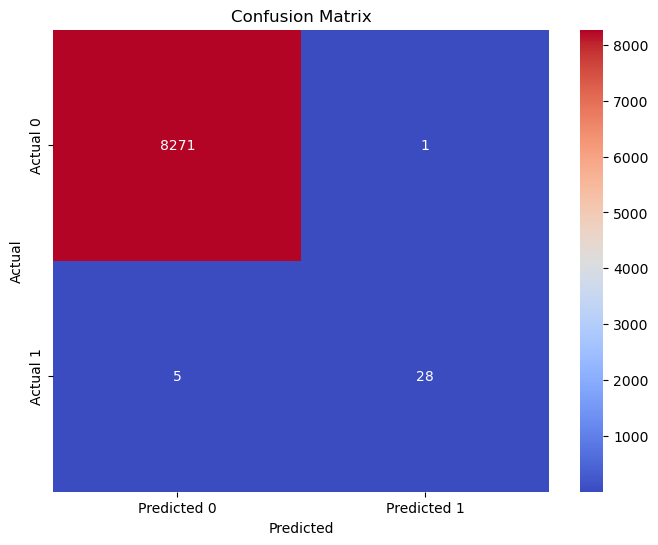

In [26]:
xgb_model_output(x_adasyn,y_adasyn,x_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best Score: 0.9989534501047166
XGB Best Model Recall: 0.8484848484848485
XGB Log Loss: 0.005436507077391105
XGB Confusion Matrix: 

 [[8272    0]
 [   5   28]]


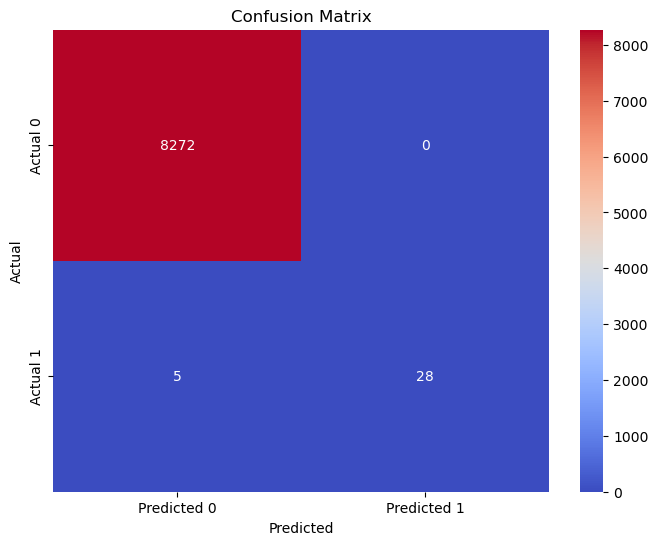

In [28]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='recall', verbose=1)

# Fit GridSearchCV Model
grid_search.fit(x_adasyn,y_adasyn)

# Best Recall Score and Parameters
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrain model with best parameters on the entire training data
best_params = grid_search.best_params_
xgb_adasyn_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
xgb_adasyn_model.fit(x_train, y_train)


# Predict for test using the best model
y_pred_xgb_adasyn = xgb_adasyn_model.predict(x_test)
y_prob_xgb_adasyn = xgb_adasyn_model.predict_proba(x_test)
recall_xgb_adasyn = recall_score(y_test, y_pred_xgb_adasyn)
LogLoss_xgb_adasyn = log_loss(y_test, y_prob_xgb_adasyn)
print(f'XGB Best Model Recall: {recall_xgb_adasyn}')
print(f'XGB Log Loss: {LogLoss_xgb_adasyn}')
print('XGB Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_xgb_adasyn))

# Displaying Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb_adasyn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

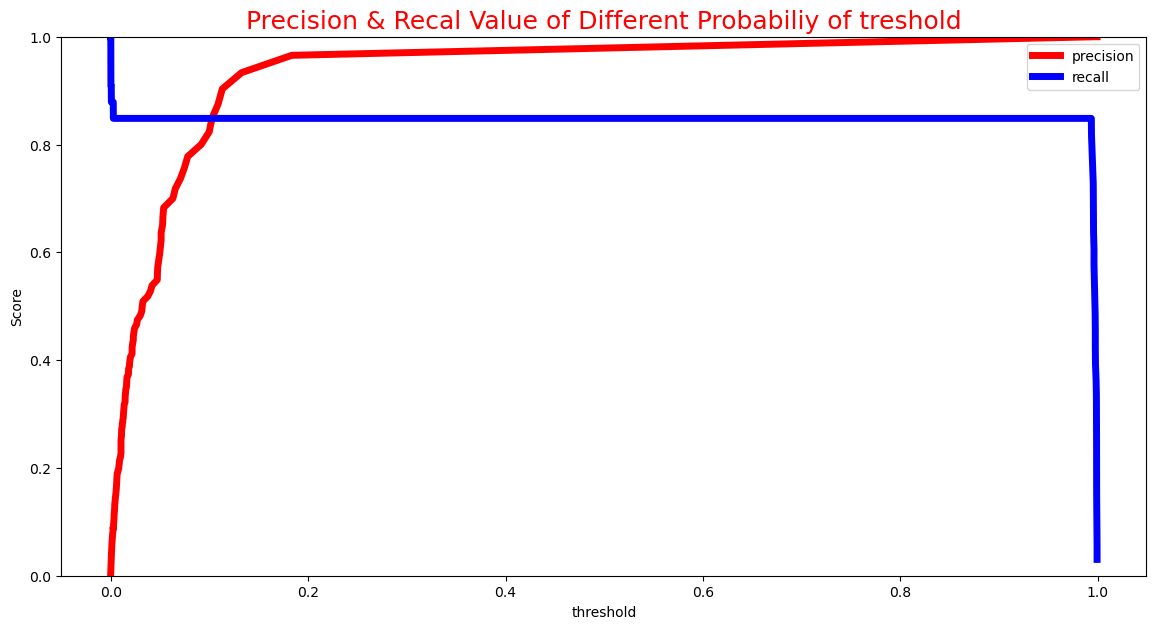

In [29]:
y_scores = xgb_adasyn_model.predict_proba(x_test)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_test, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=10)
    plt.ylabel('Score', fontsize = 10)
    plt.legend(loc="upper right", fontsize=10)
    plt.ylim([0, 1])
    plt.title('Precision & Recal Value of Different Probabiliy of treshold', fontsize = 18, c = 'r')

plt.figure(figsize=[14, 7])
plot_precision_and_recall(precision, recall, threshold)

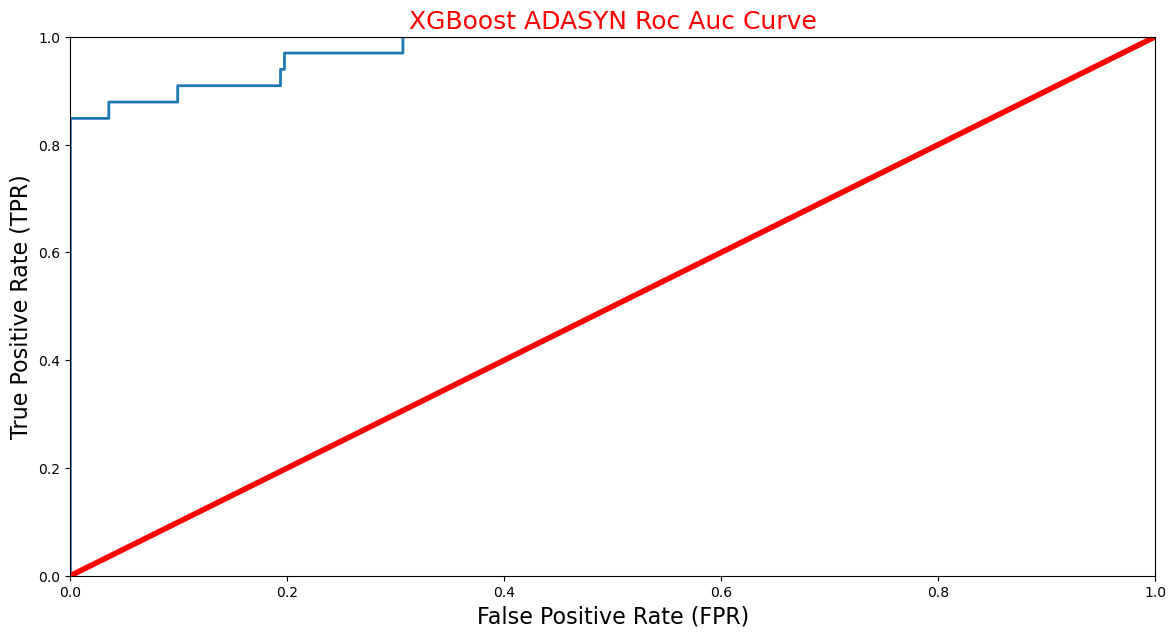

In [30]:
from sklearn.metrics import roc_curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.title('XGBoost ADASYN Roc Auc Curve', fontsize = 18, color = 'r')

plt.figure(figsize=[14, 7])
plot_roc_curve(false_positive_rate, true_positive_rate)

In [31]:
dump(xgb_adasyn_model, 'xgb_adasyn_model.pkl')

['xgb_adasyn_model.pkl']